<a href="https://colab.research.google.com/github/aviralsomani/driv-face-classifier/blob/master/AviralSomani_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=d2d1ca63969b30a8903dd67cbaa88346b1ab468393da4c0224a9116079cd3a15
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import wget
import os
from zipfile import PyZipFile
import shutil
import glob
import pandas as pd
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import random
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

tmp_dir = 'data/tmp'
img_dir = 'data/img'
trn_dir = 'data/trn'
val_dir = 'data/val'
uci_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00378/DrivFace.zip'

Using TensorFlow backend.


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
def load_data():
  if not os.path.exists(img_dir):
    os.makedirs(tmp_dir)
    os.makedirs(img_dir)
    print("Downloading dataset to "+ tmp_dir)
    file = wget.download(uci_url, out=tmp_dir)
    print("\nUnzipping the files..")
    pzf = PyZipFile(file)
    pzf.extractall(tmp_dir)
    pzf = PyZipFile(tmp_dir + '/DrivFace/DrivImages.zip')
    pzf.extractall(tmp_dir)
    print("Moving files to " + img_dir)
    for file in os.listdir(tmp_dir + '/DrivImages'):
      shutil.move(tmp_dir+'/DrivImages/'+file, img_dir+'/'+file)
    shutil.move(tmp_dir + '/DrivFace/drivPoints.txt', img_dir + '/drivPoints.txt')
    shutil.rmtree(tmp_dir)

In [0]:
def move_train_val(train_dir, validation_dir, files, ratio):
  ind = 0
  for fname in files:
    src = os.path.join(img_dir, fname + '.jpg')
    t_dest = os.path.join(train_dir, fname + '')
    ind = ind + 1
    if ind < len(files)*ratio:
      shutil.move(os.path.join(img_dir, fname + '.jpg'),
                  os.path.join(train_dir, fname + '.jpg'))
    else:
      shutil.move(os.path.join(img_dir, fname + '.jpg'),
                  os.path.join(validation_dir, fname + '.jpg'))

In [0]:
import matplotlib.pyplot as plt
def show_plots(hist):
  acc = hist.history['acc']
  val_acc = hist.history['val_acc']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.ylim(0, 1)
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
  plt.plot(epochs, acc, 'bo', label='Training Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


In [0]:
def split_data(img_dir, trn_dir, val_dir, ratio):
  if not os.path.exists(trn_dir):
    os.makedirs(trn_dir)
    os.makedirs(val_dir)
    tff_dir = os.path.join(trn_dir, 'ff')
    tll_dir = os.path.join(trn_dir, 'll')
    tlr_dir = os.path.join(trn_dir, 'lr')
    os.makedirs(tff_dir)
    os.makedirs(tll_dir)
    os.makedirs(tlr_dir)
    vff_dir = os.path.join(val_dir, 'ff')
    vll_dir = os.path.join(val_dir, 'll')
    vlr_dir = os.path.join(val_dir, 'lr')
    os.makedirs(vff_dir)
    os.makedirs(vll_dir)
    os.makedirs(vlr_dir)
    df = pd.read_csv(img_dir + '/drivPoints.txt')['fileName']
    ff = [f for f in df if 'f' in f]
    random.shuffle(ff)
    ll = [f for f in df if 'll' in f]
    random.shuffle(ll)
    lr = [f for f in df if 'lr' in f]
    random.shuffle(lr)
    ind = 0
    move_train_val(tff_dir, vff_dir, ff, ratio)
    move_train_val(tll_dir, vll_dir, ll, ratio)
    move_train_val(tlr_dir, vlr_dir, lr, ratio)

In [0]:
def return_data(img_dir, trn_dir, val_dir):
  for out in [trn_dir, val_dir]:
    for lab in ['ff', 'll', 'lr']:
      src = os.path.join(out, lab)
      files = os.listdir(src)
      for f in files:
        shutil.move(os.path.join(src, f), img_dir)
    shutil.rmtree(out)

In [0]:
def split_k_bins(trn_dir, k):
  bins = range(0, k)
  for b in bins:
    path = os.path.join(trn_dir, ('b'+str(b)))
    if not os.path.exists(path):
      os.makedirs(path)
      os.makedirs(os.path.join(path, 'ff'))
      os.makedirs(os.path.join(path, 'll'))
      os.makedirs(os.path.join(path, 'lr'))
  for lab in ['ff', 'll', 'lr']:
    src = os.path.join(trn_dir, lab)
    for f in os.listdir(src):
      bin_dir = os.path.join(trn_dir, ('b' + str(random.choice(bins))))
      shutil.move(os.path.join(src, f), os.path.join(bin_dir, lab))
    shutil.rmtree(src)

In [0]:
def coalesce_train_val(trn_dir, j):
  target = 'b' + str(j)
  bins = [b for b in os.listdir(trn_dir) if b != target]
  ingroup = os.path.join(trn_dir, 'in')
  os.makedirs(ingroup)
  os.makedirs(os.path.join(ingroup, 'ff'))
  os.makedirs(os.path.join(ingroup, 'll'))
  os.makedirs(os.path.join(ingroup, 'lr'))
  for b in bins:
    src = os.path.join(trn_dir, b)
    for lab in ['ff', 'll', 'lr']:
      srclab = os.path.join(src, lab)
      for f in os.listdir(srclab):
        shutil.copy(os.path.join(srclab, f), os.path.join(ingroup, lab))
  outgroup = os.path.join(trn_dir, 'out')
  os.makedirs(outgroup)
  os.makedirs(os.path.join(outgroup, 'ff'))
  os.makedirs(os.path.join(outgroup, 'll'))
  os.makedirs(os.path.join(outgroup, 'lr'))
  outbin = os.path.join(trn_dir, target)
  for lab in ['ff', 'll', 'lr']:
    srclab = os.path.join(outbin, lab)
    for f in os.listdir(srclab):
      shutil.copy(os.path.join(srclab, f), os.path.join(outgroup, lab))


In [0]:
def decoalesce_train_val(trn_dir):
  ingroup = os.path.join(trn_dir, 'in')
  outgroup = os.path.join(trn_dir, 'out')
  shutil.rmtree(ingroup)
  shutil.rmtree(outgroup)

In [0]:
def return_bins(trn_dir):
  bins = os.listdir(trn_dir)
  os.makedirs(os.path.join(trn_dir, 'ff'))
  os.makedirs(os.path.join(trn_dir, 'll'))
  os.makedirs(os.path.join(trn_dir, 'lr'))
  for b in bins:
    src = os.path.join(trn_dir, b)
    for lab in ['ff', 'll', 'lr']:
      insrc = os.path.join(src, lab)
      for f in os.listdir(insrc):
        shutil.move(os.path.join(insrc, f), os.path.join(trn_dir, lab))
    shutil.rmtree(src)

In [0]:
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [0]:
def run_k_fold_cross_val(model, k, steps_per_epoch=100, epochs=10, validation_steps=50):
  tr_dgen = ImageDataGenerator(rescale=1./255)
  vl_dgen = ImageDataGenerator(rescale=1./255)
  split_k_bins(trn_dir, k)
  for i in range(0, k):
    print('Bin ', i, 'out of', k)
    coalesce_train_val(trn_dir, i)
    tr_gen = tr_dgen.flow_from_directory(os.path.join(trn_dir, 'in'), target_size=(64, 64),
                                         batch_size=20, class_mode='categorical')

    vl_gen = vl_dgen.flow_from_directory(os.path.join(trn_dir, 'out'), target_size=(64, 64),
                                         batch_size=20, class_mode='categorical')
                                         
    hist = model.fit_generator(tr_gen, steps_per_epoch=steps_per_epoch, epochs=epochs,
                               validation_data=vl_gen, validation_steps=validation_steps)
    show_plots(hist)
    decoalesce_train_val(trn_dir)
  return_bins(trn_dir)


In [15]:
load_data()
split_data(img_dir, trn_dir, val_dir, 0.8)


Unzipping the files..
Moving files to data/img


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        padding='same', 
                        input_shape=(64, 64, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', 
                        padding='same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation='relu',
                        padding='same'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

Found 325 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 16s 164ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 5.5062e-05 - val_acc: 0.9939
Epoch 2/10
100/100 [==============================] - 16s 164ms/step - loss: 2.1121e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.9929
Epoch 3/10
100/100 [==============================] - 16s 163ms/step - loss: 0.0332 - acc: 0.9958 - val_loss: 0.0000e+00 - val_acc: 0.9808
Epoch 4/10
100/100 [==============================] - 16s 163ms/step - loss: 0.0188 - acc: 0.9979 - val_loss: 0.0000e+00 - val_acc: 0.9878
Epoch 5/10
100/100 [==============================] - 16s 162ms/step - loss: 0.0118 - acc: 0.9990 - val_loss: 2.6762e-06 - val_acc: 0.9818
Epoch 6/10
100/100 [==============================] - 16s 160ms/step - loss: 6.9303e-05 - acc: 1.0000 - val_loss: 0.3383 - val_acc: 0.9798
Epoch 7/10
100/100 [==============================] - 16s 160ms/step - loss: 2.9

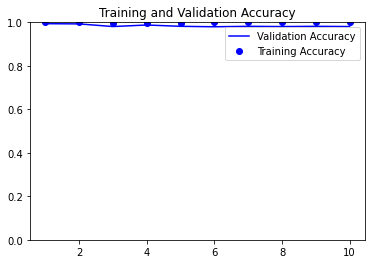

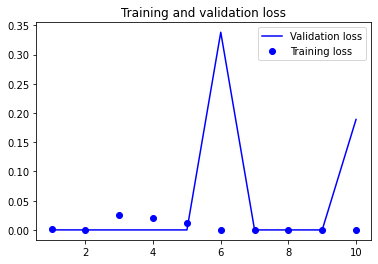

Found 326 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 166ms/step - loss: 0.0132 - acc: 0.9974 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 161ms/step - loss: 0.0053 - acc: 0.9984 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 161ms/step - loss: 3.9225e-05 - acc: 1.0000 - val_loss: 5.6624e-07 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 163ms/step - loss: 1.2022e-06 - acc: 1.0000 - val_loss: 1.6830e-07 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 160ms/step - loss: 0.0350 - acc: 0.9933 - val_loss: 0.2318 - val_acc: 0.9725
Epoch 6/10
100/100 [==============================] - 16s 158ms/step - loss: 0.0417 - acc: 0.9932 - val_loss: 0.1592 - val_acc: 0.9939
Epoch 7/10
100/100 [==============================] - 16s 160ms/step - loss: 0.0860 

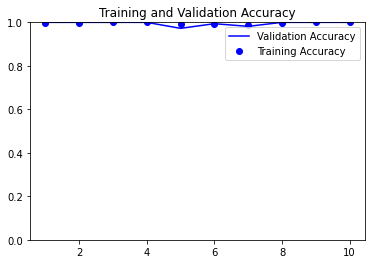

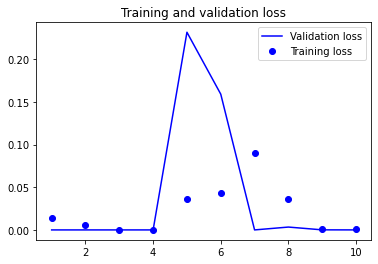

Found 315 images belonging to 3 classes.
Found 168 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 172ms/step - loss: 0.0210 - acc: 0.9969 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 160ms/step - loss: 2.5951e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 159ms/step - loss: 1.3271e-05 - acc: 1.0000 - val_loss: 5.9605e-09 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 164ms/step - loss: 8.5265e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 157ms/step - loss: 1.3816e-05 - acc: 1.0000 - val_loss: 5.9605e-09 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 16s 158ms/step - loss: 1.6137e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 16s 156ms/

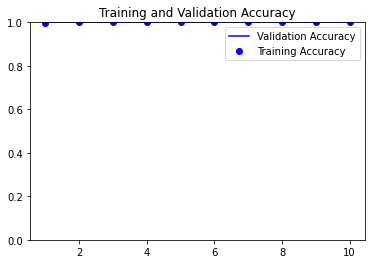

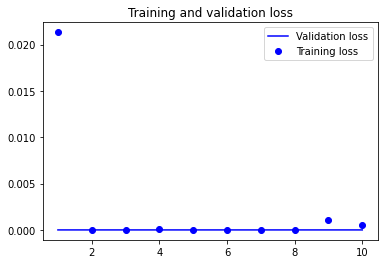

In [0]:
run_k_fold_cross_val(model, k=3)

In [0]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(64, 64),
                                         batch_size=20, class_mode='categorical')

Found 123 images belonging to 3 classes.


In [0]:
model2 = models.Sequential()
model2.add(layers.Conv2D(256, (3, 3), activation='relu', 
                         padding='same', 
                         input_shape=(64, 64, 3)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu',
                        padding='same'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 256)       7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

Bin  0 out of 15
Found 445 images belonging to 3 classes.
Found 38 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 19s 194ms/step - loss: 0.5317 - acc: 0.8742 - val_loss: 0.4487 - val_acc: 0.9211
Epoch 2/5
100/100 [==============================] - 13s 127ms/step - loss: 0.3408 - acc: 0.9031 - val_loss: 0.3569 - val_acc: 0.9211
Epoch 3/5
100/100 [==============================] - 13s 130ms/step - loss: 0.2926 - acc: 0.9013 - val_loss: 0.4656 - val_acc: 0.9211
Epoch 4/5
100/100 [==============================] - 13s 127ms/step - loss: 0.2352 - acc: 0.9036 - val_loss: 0.2261 - val_acc: 0.9474
Epoch 5/5
100/100 [==============================] - 13s 126ms/step - loss: 0.1840 - acc: 0.9252 - val_loss: 0.1086 - val_acc: 0.9737


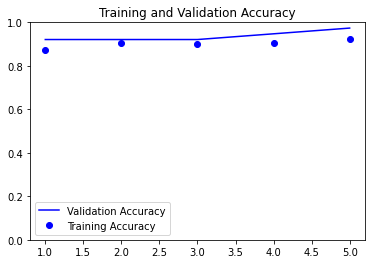

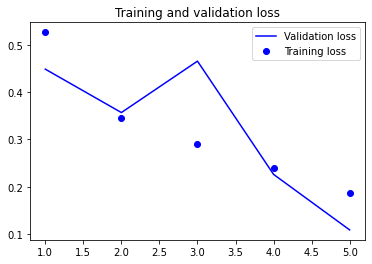

Bin  1 out of 15
Found 449 images belonging to 3 classes.
Found 34 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 136ms/step - loss: 0.1452 - acc: 0.9448 - val_loss: 0.1030 - val_acc: 0.9706
Epoch 2/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0956 - acc: 0.9635 - val_loss: 0.0960 - val_acc: 0.9706
Epoch 3/5
100/100 [==============================] - 13s 131ms/step - loss: 0.0842 - acc: 0.9652 - val_loss: 0.0416 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0636 - acc: 0.9760 - val_loss: 0.0058 - val_acc: 0.9706
Epoch 5/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0567 - acc: 0.9825 - val_loss: 0.1133 - val_acc: 0.9706


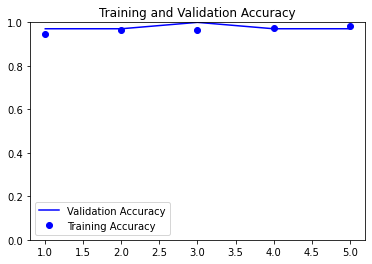

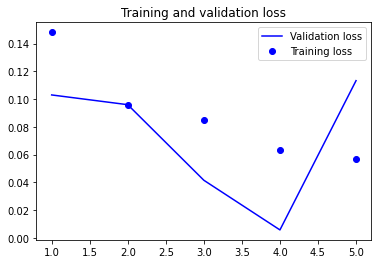

Bin  2 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 136ms/step - loss: 0.0458 - acc: 0.9822 - val_loss: 3.1817e-04 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0394 - acc: 0.9811 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 130ms/step - loss: 0.0430 - acc: 0.9857 - val_loss: 8.6921e-06 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0164 - acc: 0.9954 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 126ms/step - loss: 0.0133 - acc: 0.9969 - val_loss: 9.9341e-09 - val_acc: 1.0000


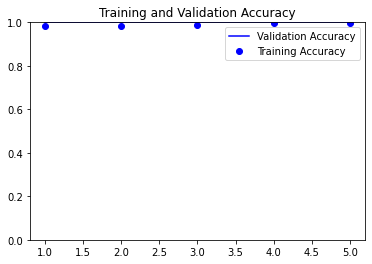

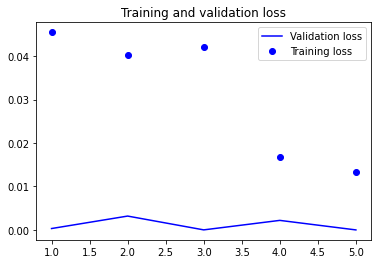

Bin  3 out of 15
Found 443 images belonging to 3 classes.
Found 40 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 137ms/step - loss: 0.0166 - acc: 0.9958 - val_loss: 2.1544e-04 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 126ms/step - loss: 0.0164 - acc: 0.9933 - val_loss: 9.9618e-05 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 130ms/step - loss: 0.0273 - acc: 0.9906 - val_loss: 4.3511e-07 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 130ms/step - loss: 0.0357 - acc: 0.9881 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 126ms/step - loss: 0.0132 - acc: 0.9958 - val_loss: 0.0011 - val_acc: 1.0000


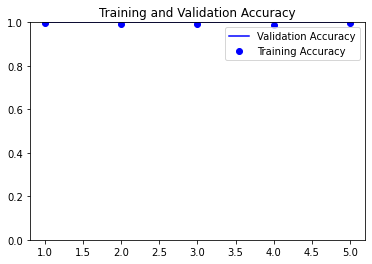

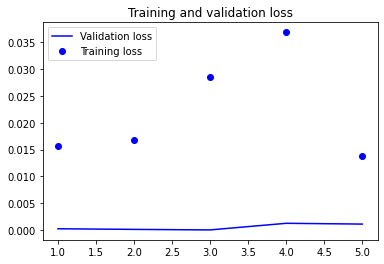

Bin  4 out of 15
Found 444 images belonging to 3 classes.
Found 39 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 138ms/step - loss: 0.0091 - acc: 0.9974 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 126ms/step - loss: 0.0087 - acc: 0.9959 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 131ms/step - loss: 0.0094 - acc: 0.9969 - val_loss: 1.8229e-04 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 129ms/step - loss: 0.0089 - acc: 0.9979 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0259 - acc: 0.9943 - val_loss: 0.0167 - val_acc: 1.0000


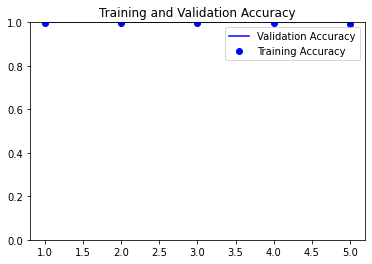

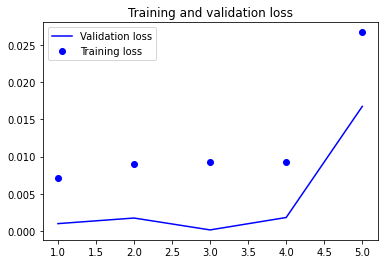

Bin  5 out of 15
Found 455 images belonging to 3 classes.
Found 28 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 137ms/step - loss: 0.0042 - acc: 0.9985 - val_loss: 2.4450e-05 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 12s 123ms/step - loss: 0.0102 - acc: 0.9965 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0137 - acc: 0.9934 - val_loss: 1.4901e-08 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 12s 125ms/step - loss: 0.0086 - acc: 0.9970 - val_loss: 0.0986 - val_acc: 0.9643
Epoch 5/5
100/100 [==============================] - 12s 124ms/step - loss: 0.0066 - acc: 0.9985 - val_loss: 2.9802e-08 - val_acc: 1.0000


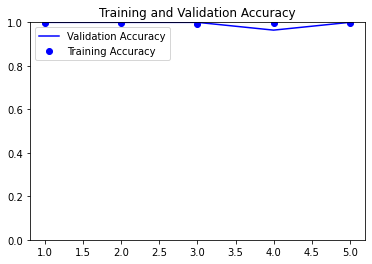

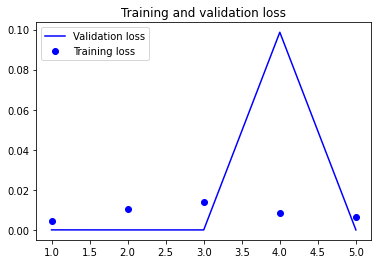

Bin  6 out of 15
Found 438 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 125ms/step - loss: 0.0058 - acc: 0.9985 - val_loss: 0.0102 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 12s 117ms/step - loss: 0.0091 - acc: 0.9960 - val_loss: 1.6580e-04 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 114ms/step - loss: 0.0071 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 12s 118ms/step - loss: 0.0019 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 112ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 7.4031e-04 - val_acc: 1.0000


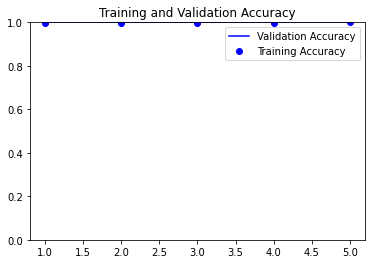

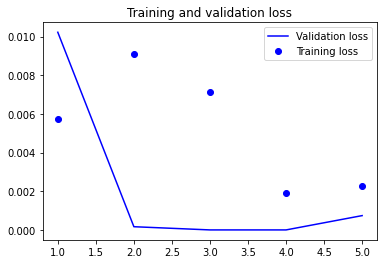

Bin  7 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 13s 135ms/step - loss: 0.0189 - acc: 0.9944 - val_loss: 4.3560e-05 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 125ms/step - loss: 0.0212 - acc: 0.9939 - val_loss: 3.0796e-07 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 131ms/step - loss: 0.0077 - acc: 0.9980 - val_loss: 9.9341e-09 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 127ms/step - loss: 0.0089 - acc: 0.9959 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0032 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000


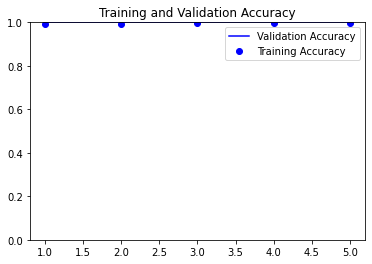

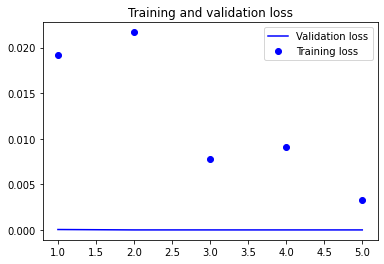

Bin  8 out of 15
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 118ms/step - loss: 0.0061 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 107ms/step - loss: 0.0018 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 114ms/step - loss: 0.0011 - acc: 0.9995 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 112ms/step - loss: 8.7895e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0037 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000


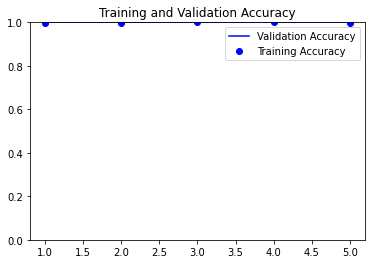

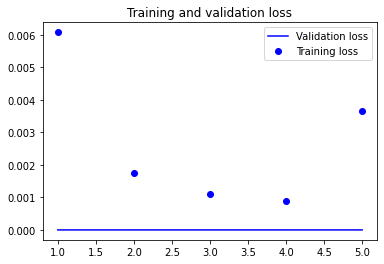

Bin  9 out of 15
Found 457 images belonging to 3 classes.
Found 26 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 123ms/step - loss: 0.0062 - acc: 0.9975 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 109ms/step - loss: 0.0094 - acc: 0.9965 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 113ms/step - loss: 0.0544 - acc: 0.9889 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0067 - acc: 0.9970 - val_loss: 1.9868e-08 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 110ms/step - loss: 0.0050 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000


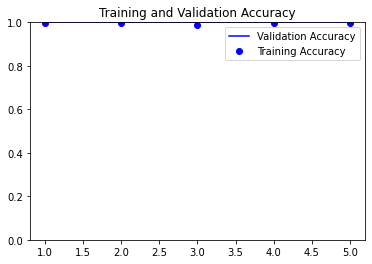

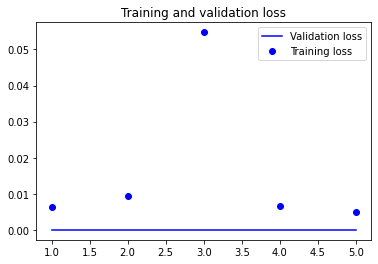

Bin  10 out of 15
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 117ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 3.6061e-06 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 107ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 5.3644e-07 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 113ms/step - loss: 0.0034 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 107ms/step - loss: 0.0137 - acc: 0.9975 - val_loss: 6.2585e-07 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 107ms/step - loss: 0.0068 - acc: 0.9980 - val_loss: 5.0664e-07 - val_acc: 1.0000


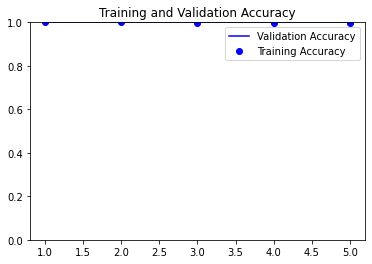

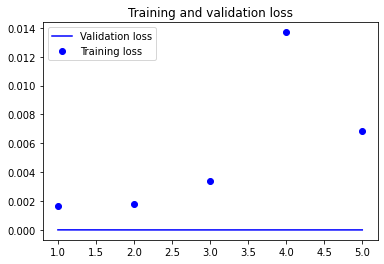

Bin  11 out of 15
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 117ms/step - loss: 0.0290 - acc: 0.9950 - val_loss: 1.7285e-06 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0018 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 108ms/step - loss: 6.4126e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 108ms/step - loss: 0.0034 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000


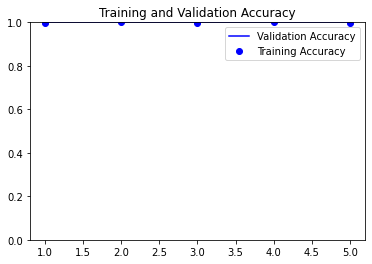

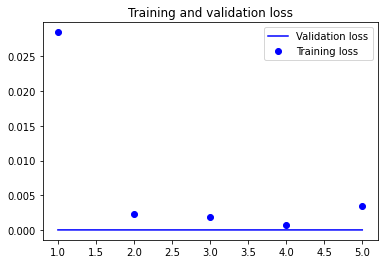

Bin  12 out of 15
Found 446 images belonging to 3 classes.
Found 37 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 136ms/step - loss: 0.0030 - acc: 0.9995 - val_loss: 7.0123e-09 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 126ms/step - loss: 6.5357e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 131ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 130ms/step - loss: 3.7162e-04 - acc: 1.0000 - val_loss: 6.4159e-06 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 126ms/step - loss: 4.2424e-04 - acc: 1.0000 - val_loss: 1.3043e-06 - val_acc: 1.0000


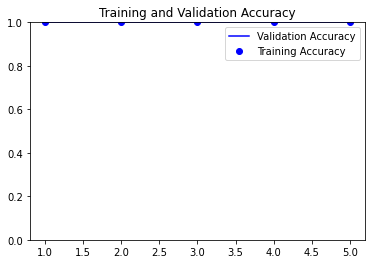

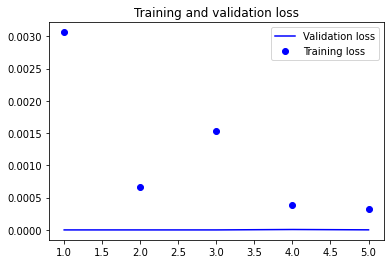

Bin  13 out of 15
Found 455 images belonging to 3 classes.
Found 28 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 13s 134ms/step - loss: 4.6215e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 12s 123ms/step - loss: 2.6949e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 128ms/step - loss: 3.1736e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 12s 124ms/step - loss: 6.7445e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 126ms/step - loss: 0.0010 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000


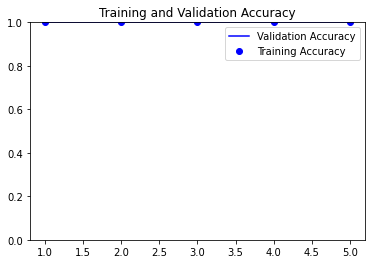

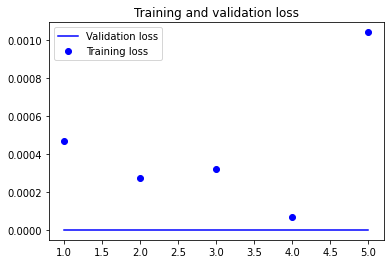

Bin  14 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 136ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 126ms/step - loss: 0.0772 - acc: 0.9878 - val_loss: 0.2400 - val_acc: 0.9688
Epoch 3/5
100/100 [==============================] - 13s 131ms/step - loss: 0.0151 - acc: 0.9934 - val_loss: 0.0150 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 128ms/step - loss: 0.0056 - acc: 0.9985 - val_loss: 1.9868e-08 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 125ms/step - loss: 0.0010 - acc: 0.9995 - val_loss: 2.2848e-07 - val_acc: 1.0000


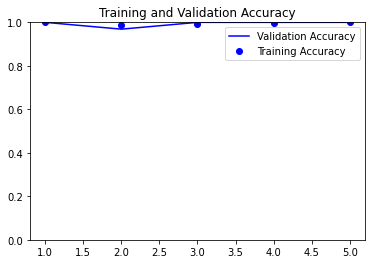

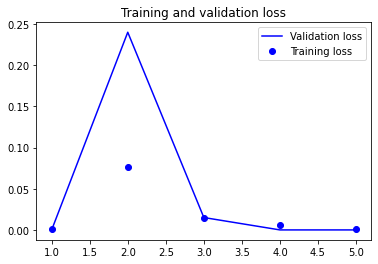

In [0]:
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

run_k_fold_cross_val(model2, 15, steps_per_epoch=100, epochs=5, validation_steps=50)

In [0]:
model2.evaluate_generator(test_gen)

[7.94728478581419e-08, 0.9430894255638123]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 256)       7168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

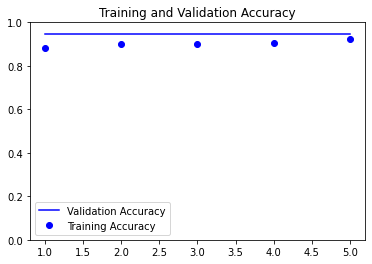

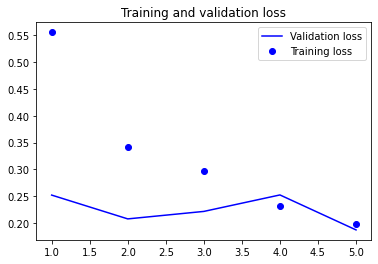

Bin  1 out of 20
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 15s 147ms/step - loss: 0.1600 - acc: 0.9308 - val_loss: 0.0124 - val_acc: 0.9062
Epoch 2/5
100/100 [==============================] - 14s 136ms/step - loss: 0.1178 - acc: 0.9504 - val_loss: 0.5854 - val_acc: 0.9375
Epoch 3/5
100/100 [==============================] - 14s 143ms/step - loss: 0.1003 - acc: 0.9572 - val_loss: 0.7943 - val_acc: 0.9375
Epoch 4/5
100/100 [==============================] - 14s 137ms/step - loss: 0.0901 - acc: 0.9652 - val_loss: 0.0115 - val_acc: 0.9688
Epoch 5/5
100/100 [==============================] - 14s 136ms/step - loss: 0.0780 - acc: 0.9695 - val_loss: 0.7002 - val_acc: 0.9688


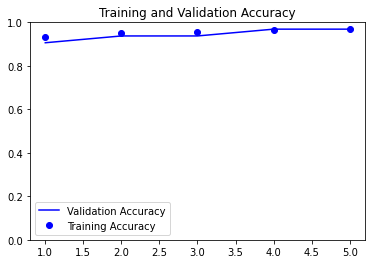

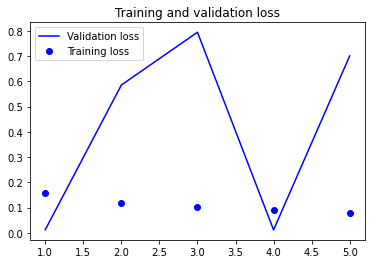

Bin  2 out of 20
Found 464 images belonging to 3 classes.
Found 19 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 15s 151ms/step - loss: 0.0768 - acc: 0.9737 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 14s 142ms/step - loss: 0.0550 - acc: 0.9814 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 14s 141ms/step - loss: 0.0318 - acc: 0.9875 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 14s 140ms/step - loss: 0.0426 - acc: 0.9857 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 14s 141ms/step - loss: 0.0539 - acc: 0.9812 - val_loss: 0.0165 - val_acc: 1.0000


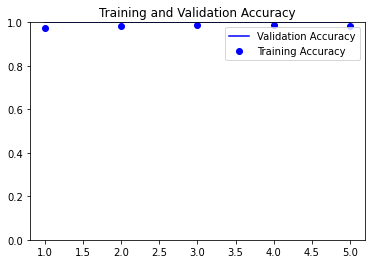

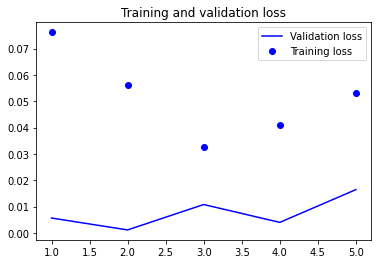

Bin  3 out of 20
Found 463 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 15s 147ms/step - loss: 0.0497 - acc: 0.9845 - val_loss: 0.0228 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 14s 142ms/step - loss: 0.0361 - acc: 0.9891 - val_loss: 0.0212 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 14s 143ms/step - loss: 0.0185 - acc: 0.9927 - val_loss: 6.6434e-05 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 14s 140ms/step - loss: 0.0148 - acc: 0.9943 - val_loss: 1.3749e-04 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 14s 140ms/step - loss: 0.0202 - acc: 0.9917 - val_loss: 0.0026 - val_acc: 1.0000


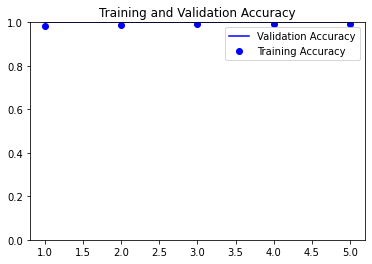

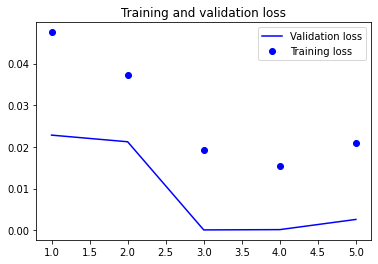

Bin  4 out of 20
Found 462 images belonging to 3 classes.
Found 21 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 13s 125ms/step - loss: 0.0198 - acc: 0.9933 - val_loss: 0.0000e+00 - val_acc: 0.9524
Epoch 2/5
100/100 [==============================] - 11s 114ms/step - loss: 0.0210 - acc: 0.9927 - val_loss: 0.0019 - val_acc: 0.9524
Epoch 3/5
100/100 [==============================] - 12s 116ms/step - loss: 0.0185 - acc: 0.9943 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 12s 116ms/step - loss: 0.0127 - acc: 0.9948 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 114ms/step - loss: 0.0125 - acc: 0.9959 - val_loss: 2.9802e-06 - val_acc: 1.0000


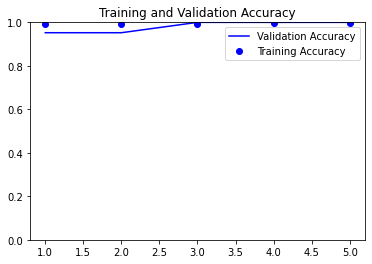

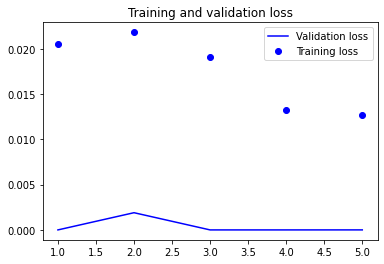

Bin  5 out of 20
Found 456 images belonging to 3 classes.
Found 27 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 15s 147ms/step - loss: 0.0138 - acc: 0.9960 - val_loss: 2.6506e-04 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 14s 136ms/step - loss: 0.0075 - acc: 0.9970 - val_loss: 2.2722e-04 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 14s 142ms/step - loss: 0.0041 - acc: 0.9980 - val_loss: 2.1848e-05 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 14s 137ms/step - loss: 0.0046 - acc: 0.9975 - val_loss: 2.2650e-06 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 134ms/step - loss: 0.0116 - acc: 0.9970 - val_loss: 8.2082e-06 - val_acc: 1.0000


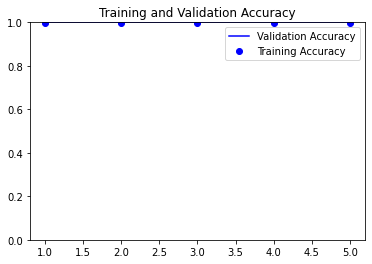

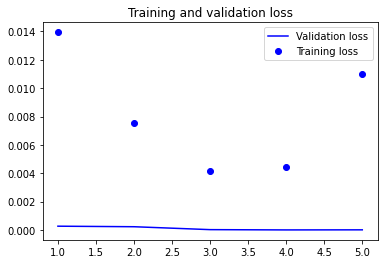

Bin  6 out of 20
Found 465 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 15s 150ms/step - loss: 0.0064 - acc: 0.9979 - val_loss: 7.9473e-08 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 14s 138ms/step - loss: 0.0071 - acc: 0.9979 - val_loss: 1.7881e-07 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 14s 140ms/step - loss: 0.0080 - acc: 0.9959 - val_loss: 6.1259e-06 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 14s 137ms/step - loss: 0.0032 - acc: 0.9995 - val_loss: 9.6692e-07 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 14s 139ms/step - loss: 0.0428 - acc: 0.9881 - val_loss: 0.0204 - val_acc: 1.0000


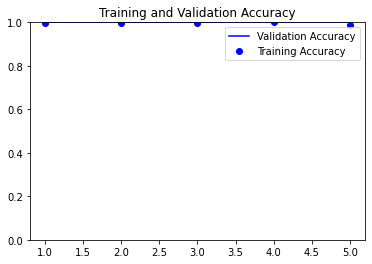

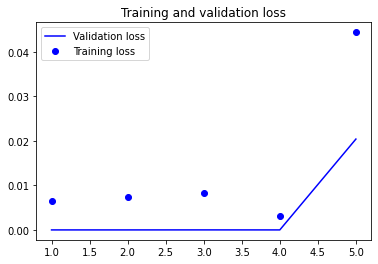

Bin  7 out of 20
Found 457 images belonging to 3 classes.
Found 26 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 144ms/step - loss: 0.0261 - acc: 0.9924 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 133ms/step - loss: 0.0213 - acc: 0.9920 - val_loss: 1.0033e-05 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 14s 136ms/step - loss: 0.0083 - acc: 0.9965 - val_loss: 1.1524e-06 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 133ms/step - loss: 0.0062 - acc: 0.9980 - val_loss: 2.8610e-06 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 132ms/step - loss: 0.0043 - acc: 0.9985 - val_loss: 2.9802e-07 - val_acc: 1.0000


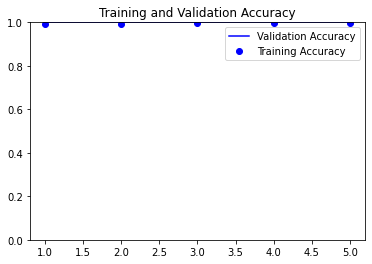

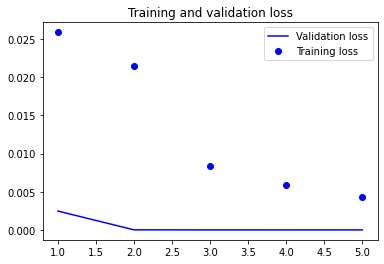

Bin  8 out of 20
Found 458 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 142ms/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 135ms/step - loss: 0.0069 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 135ms/step - loss: 0.0033 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 130ms/step - loss: 0.0024 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 126ms/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000


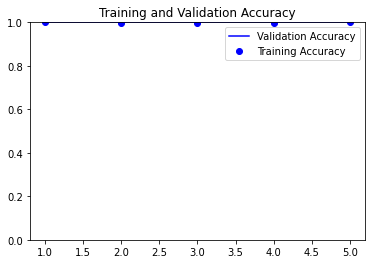

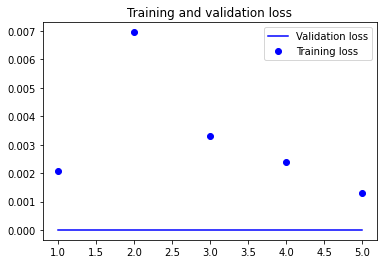

Bin  9 out of 20
Found 453 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 15s 146ms/step - loss: 0.0130 - acc: 0.9954 - val_loss: 1.9312e-06 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 133ms/step - loss: 0.0037 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 14s 139ms/step - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 14s 136ms/step - loss: 0.0129 - acc: 0.9959 - val_loss: 5.4729e-05 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 132ms/step - loss: 0.0240 - acc: 0.9939 - val_loss: 0.0097 - val_acc: 1.0000


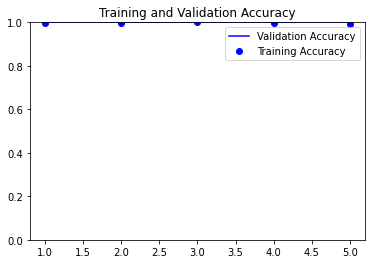

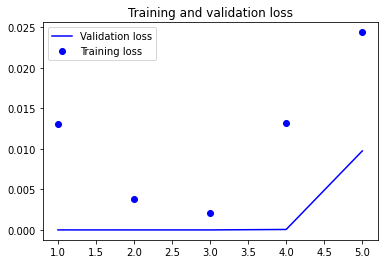

Bin  10 out of 20
Found 461 images belonging to 3 classes.
Found 22 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 122ms/step - loss: 0.0063 - acc: 0.9974 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 112ms/step - loss: 0.0058 - acc: 0.9984 - val_loss: 3.1590e-06 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 112ms/step - loss: 0.0170 - acc: 0.9938 - val_loss: 0.0000e+00 - val_acc: 0.9545
Epoch 4/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0046 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 0.9545
Epoch 5/5
100/100 [==============================] - 11s 113ms/step - loss: 0.0022 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 0.9545


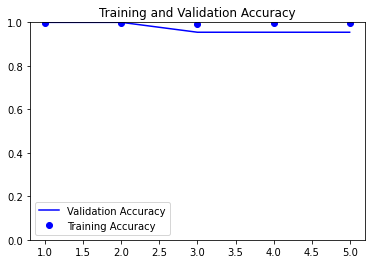

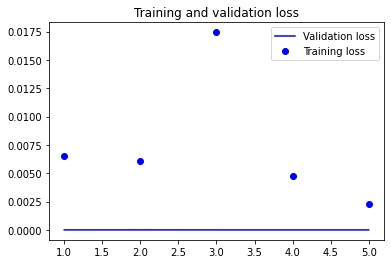

Bin  11 out of 20
Found 462 images belonging to 3 classes.
Found 21 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 121ms/step - loss: 0.0302 - acc: 0.9927 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 114ms/step - loss: 0.0122 - acc: 0.9959 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 112ms/step - loss: 0.0095 - acc: 0.9969 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 109ms/step - loss: 0.0023 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 110ms/step - loss: 8.8281e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


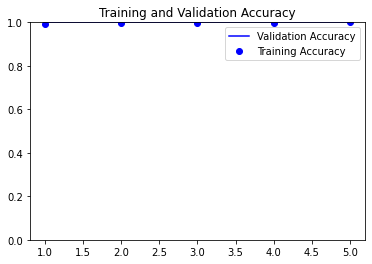

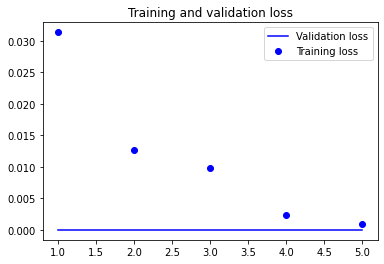

Bin  12 out of 20
Found 461 images belonging to 3 classes.
Found 22 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 120ms/step - loss: 0.0016 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 113ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 112ms/step - loss: 7.0546e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 109ms/step - loss: 9.0443e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 110ms/step - loss: 0.0026 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000


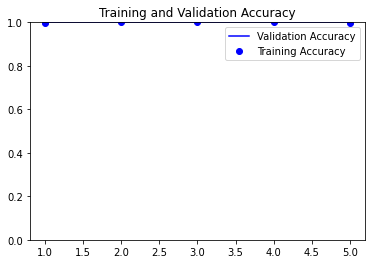

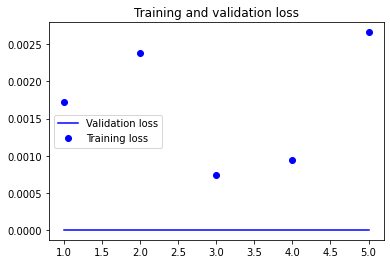

Bin  13 out of 20
Found 461 images belonging to 3 classes.
Found 22 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 12s 120ms/step - loss: 0.0023 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0108 - acc: 0.9979 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0041 - acc: 0.9984 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 110ms/step - loss: 0.0040 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 110ms/step - loss: 6.0990e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


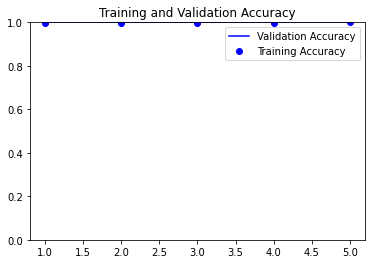

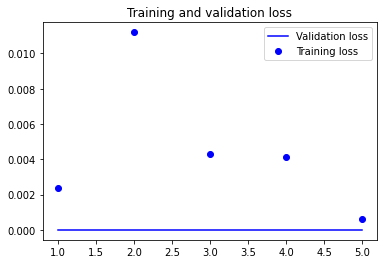

Bin  14 out of 20
Found 452 images belonging to 3 classes.
Found 31 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 143ms/step - loss: 0.0029 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 133ms/step - loss: 6.3358e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 14s 137ms/step - loss: 1.7624e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 134ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 131ms/step - loss: 0.0461 - acc: 0.9913 - val_loss: 6.5023e-08 - val_acc: 1.0000


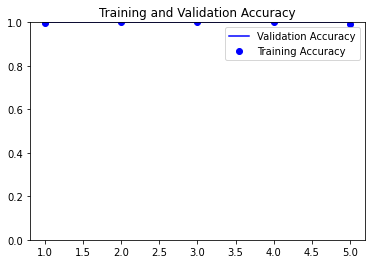

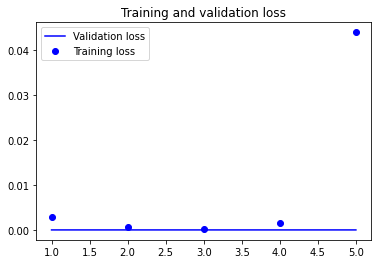

Bin  15 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 13s 125ms/step - loss: 0.0060 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0063 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 12s 117ms/step - loss: 0.0053 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 11s 114ms/step - loss: 0.0042 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 11s 111ms/step - loss: 0.0029 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000


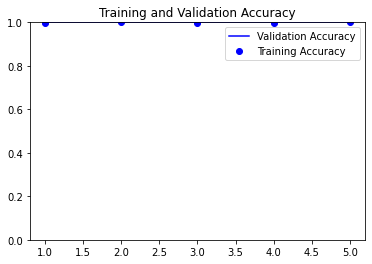

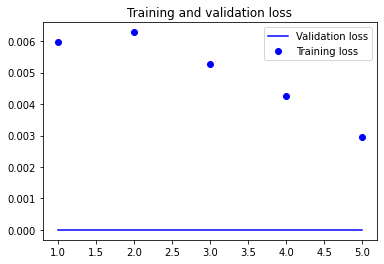

Bin  16 out of 20
Found 468 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 143ms/step - loss: 4.7673e-04 - acc: 1.0000 - val_loss: 2.0265e-06 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 134ms/step - loss: 2.3221e-04 - acc: 1.0000 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 129ms/step - loss: 6.4103e-04 - acc: 1.0000 - val_loss: 4.5299e-07 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 131ms/step - loss: 0.0011 - acc: 0.9995 - val_loss: 1.2373e-04 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 132ms/step - loss: 1.8659e-04 - acc: 1.0000 - val_loss: 2.9073e-05 - val_acc: 1.0000


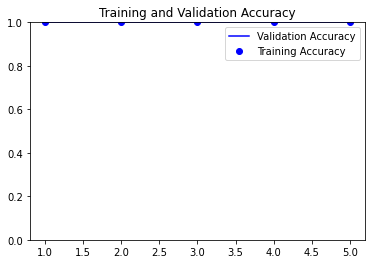

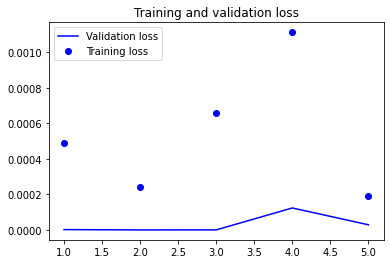

Bin  17 out of 20
Found 453 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 141ms/step - loss: 3.7698e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 131ms/step - loss: 4.2479e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 14s 136ms/step - loss: 3.3111e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 133ms/step - loss: 8.6084e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 131ms/step - loss: 5.7369e-04 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000


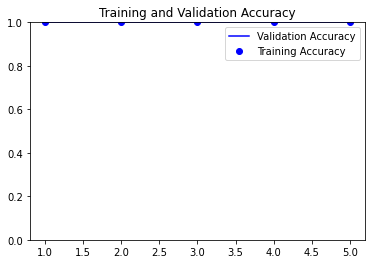

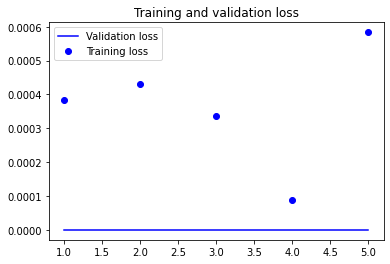

Bin  18 out of 20
Found 450 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 141ms/step - loss: 3.1837e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 130ms/step - loss: 4.0091e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 14s 136ms/step - loss: 0.0104 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 133ms/step - loss: 0.0026 - acc: 0.9985 - val_loss: 2.3346e-04 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 129ms/step - loss: 0.0389 - acc: 0.9913 - val_loss: 4.2858e-05 - val_acc: 1.0000


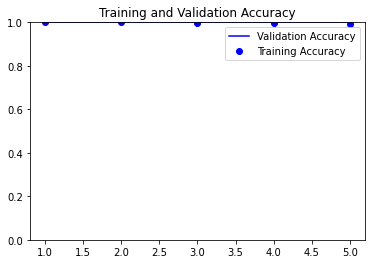

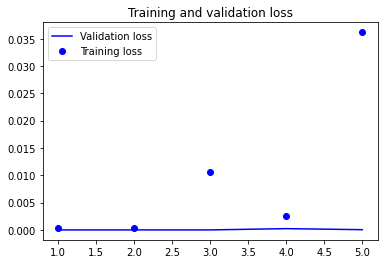

Bin  19 out of 20
Found 456 images belonging to 3 classes.
Found 27 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 14s 137ms/step - loss: 0.0082 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 13s 130ms/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 13s 134ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 13s 130ms/step - loss: 0.0048 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 13s 130ms/step - loss: 0.0081 - acc: 0.9975 - val_loss: 0.0000e+00 - val_acc: 1.0000


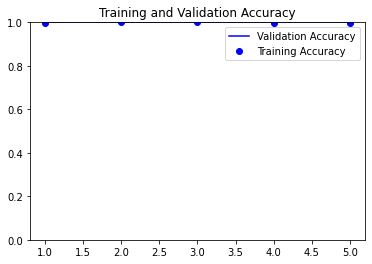

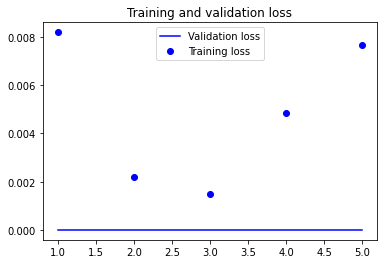

[0.0008619995205663145, 0.9593495726585388]

In [0]:
model3 = models.Sequential()
model3.add(layers.Conv2D(256, (3, 3), activation='relu', 
                         padding='same', 
                         input_shape=(64, 64, 3)))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu',
                        padding='same'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))

model3.summary()

model3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

run_k_fold_cross_val(model3, 20, steps_per_epoch=100, epochs=5, validation_steps=50)
model3.evaluate_generator(test_gen)

In [0]:
return_data(img_dir, trn_dir, val_dir)

In [0]:
split_data(img_dir, trn_dir, val_dir, 0.1)

In [22]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(64, 64),
                                         batch_size=50, class_mode='categorical')

Found 123 images belonging to 3 classes.


In [0]:
model3.evaluate_generator(test_gen)

[8.855535043039708e-07, 0.9908592104911804]

In [0]:
x, y = test_gen.next()

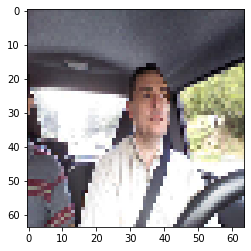

In [24]:
plt.imshow(x[1])

In [25]:
print(type(y))

<class 'numpy.ndarray'>


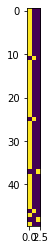

In [26]:
plt.imshow(y)